In [1]:
import os
os.chdir('..')
import Anomaly

In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import importlib
from seaborn import kdeplot
from sklearn import metrics 

In [6]:
def courbe_ROC(kernel_list, law_p, law_q, m, n, sample_size):
    for i in range(len(kernel_list)):
        y = np.zeros(2000)
        y[:1000] = 1
        scores = np.zeros(2000)
        scores[:1000] = Anomaly.estimators.sampleMMD_MC(Anomaly.MMD.OMMD, kernel_list[i], law_p, law_q, m, n, verbose=0)
        scores[1000:] = Anomaly.estimators.sampleMMD_MC(Anomaly.MMD.OMMD, kernel_list[i], law_p, law_p, m, n, verbose=0)
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        plt.plot(fpr, tpr, label=f"kernel num {i}; AUC = {metrics.auc(fpr, tpr):.2f}")
    plt.legend()

In [7]:
law_p = Anomaly.utils.normal(0,1)
law_q = Anomaly.utils.normal(0.5,1)
m = 1000
n = 100

CPU times: user 29.9 s, sys: 265 ms, total: 30.2 s
Wall time: 32.3 s


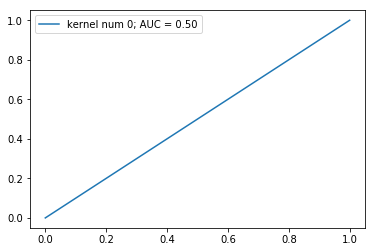

In [8]:
%time courbe_ROC([Anomaly.kernels.polynomial(c=1,d=0)], law_p, law_q, m, n, sample_size=10)

In [154]:
from numba import int64, float64
spec = [
    ('kernel', numba.typeof(kernel)),               # a simple scalar field
    ('X', numba.typeof(1)),
    ('Y',float64[:]),
    ('n',int64),
    ('m',int64),
    ('estim_normP',float64),
    ('sumNormQ',float64),
    ('sumPS',float64),
    ('MMD',float64)
]







class OMMD():
    def __init__(self, kernel):
        self.kernel = kernel
        self.X = []
        self.Y = []
        self.m = 0
        self.n = 0
        self.estim_normP = 0
        self.sumNormQ = 0
        self.sumPS = 0
        self.MMD = 0
    def update(self,y1,y2):
        self.sumNormQ += self.kernel(y1,y2)
        
        self.sumPS += self.kernel(self.X,y1).sum() + self.kernel(self.X,y2).sum()
        
        self.n += 2
        
        self.MMD = (self.estim_normP + 2/self.n * self.sumNormQ - 2/(self.n*self.m)*self.sumPS)[0]
    def fit(self, Y, X=None):
        self.X = X
        X_, Y_ = X[0::2,:],X[1::2,:]
        self.m = X.shape[0]
        self.estim_normP = 2/self.m*self.kernel(X_,Y_).sum()
        for i in range(0,Y.shape[0]//2):
            self.update(Y[2*i].reshape((1,-1)),Y[2*i+1].reshape((1,-1)))

In [168]:
law_p = Anomaly.utils.normal(0,1)
law_q = Anomaly.utils.normal(0.5,1)
kernel = Anomaly.kernels.polynomial(c=1,d=0)

m = 1000
n = 100

In [169]:
kernel = numba.njit(kernel)
law_p = numba.njit(law_p)
law_q = numba.njit(law_q)
@numba.njit
def sampleMMD_MC(kernel, law_p, law_q, m, n, finalSampleSize = 1000, verbose=1):
    
    Liste_mmdl = np.zeros(finalSampleSize)
    for _ in range(finalSampleSize):
        X = law_p(m)
        Y = law_q(n)

        MMD =  OMMD(kernel)
        MMD.fit(Y, X)
        Liste_mmdl[_] = MMD.MMD
        
    return np.r_[Liste_mmdl]

In [170]:
def courbe_ROC2(kernel_list, law_p, law_q, m, n, sample_size):
    for i in range(len(kernel_list)):
        y = np.zeros(2000)
        y[:1000] = 1
        scores = np.zeros(2000)
        scores[:1000] = sampleMMD_MC(kernel_list[i], law_p, law_q, m, n, verbose=0)
        scores[1000:] = sampleMMD_MC(kernel_list[i], law_p, law_p, m, n, verbose=0)
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)

In [171]:
%time courbe_ROC2([kernel], law_p, law_q, m, n, sample_size=10)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'OMMD':[0m [1m[1mcannot determine Numba type of <class 'type'>[0m
[1m
File "<ipython-input-169-aa0826d03723>", line 12:[0m
[1mdef sampleMMD_MC(kernel, law_p, law_q, m, n, finalSampleSize = 1000, verbose=1):
    <source elided>

[1m        MMD =  OMMD(kernel)
[0m        [1m^[0m[0m
[0m
This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [187]:
@numba.njit
def test(A,B):
    return A + B

In [ ]:
A = np.random.randn(100000000)
B = np.random.randn(100000000)

In [ ]:
%time test(A,B)
print("")